In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.primitives import StatevectorSampler as Sampler, StatevectorEstimator as Estimator

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# set random seed
algorithm_globals.random_seed = 42
sampler = Sampler()
estimator = Estimator()

In [2]:
num_qubits = 3
# combine a custom feature map and ansatz into a single circuit
qc = QNNCircuit(
    feature_map=ZFeatureMap(feature_dimension=num_qubits, reps=1),
    ansatz=RealAmplitudes(num_qubits, reps=1),
)
qc.draw(output="text", style="clifford")

┌──────────────────────────────┐»
q_0: ┤0                             ├»
     │                              │»
q_1: ┤1 ZFeatureMap(x[0],x[1],x[2]) ├»
     │                              │»
q_2: ┤2                             ├»
     └──────────────────────────────┘»
«     ┌────────────────────────────────────────────────┐
«q_0: ┤0                                               ├
«     │                                                │
«q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├
«     │                                                │
«q_2: ┤2                                               ├
«     └────────────────────────────────────────────────┘

In [3]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [4]:
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [5]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

In [6]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

In [7]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [8]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

In [9]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.6923
Number of weights: 6, normalized effective dimension: 0.7820


In [10]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)


In [11]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.6769911  4.72331563 4.74703473 4.90481794 4.95077666 5.00661989
 5.04879017 5.07739591 5.16081141 5.21626413]
Number of weights: 6


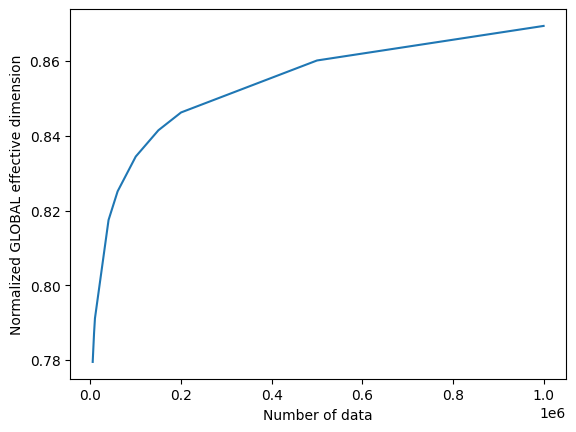

In [12]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()


In [13]:
num_inputs = 3
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

In [14]:
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [15]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=80),
    initial_point=initial_point,
    callback=callback_graph,
)

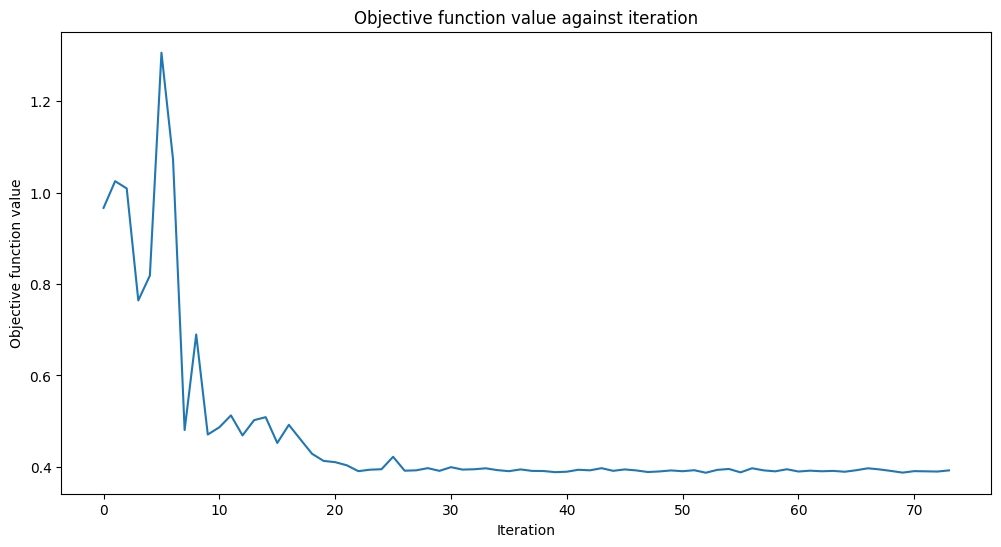

In [23]:
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [22]:
# score classifier
estimator_classifier.score(X, y)

0.94

In [21]:
trained_weights = estimator_classifier.weights

# get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=trained_weights, input_samples=X
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for trained QNN: ",
    local_eff_dim_trained / estimator_qnn.num_weights,
)

normalized local effective dimensions for trained QNN:  [0.57240606 0.58104568 0.5856312  0.61839906 0.62870066 0.64181519
 0.65227006 0.65969664 0.68328645 0.70080159]
